In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# nltk -> natural language tool kit, the library we will use basic NLP functions

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [3]:
data = pd.read_csv("data/samples/sample_20000.csv")

/tmp/ipykernel_14000/3922052023.py:1: DtypeWarning: Columns (0,2,4,11,20,22,33,35,36,41,80,81,82,84,85,89,92,95,96,100,101,113,114,121,123,130,134,135,136,144,147,155,162,164,168,169,172,173,174,175,176) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/samples/sample_20000.csv")


## Lemmatizing and stemming the docs 

In [4]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Stem each token
    
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    # Join the tokens back into a string
    return " ".join(stemmed_tokens)

In [5]:
data_subset = data.sample(n=100, random_state=42)

data_subset["selftext_string"] = data_subset["selftext"].astype(str)
data_subset["selftext_preprocessed"] = data_subset["selftext_string"].apply(preprocess)
print(data_subset["selftext_preprocessed"].head(5).values)

["my ex and i were togeth for two year , and she is my first lover . we had a tough breakup due to distanc and my parent ' object . thi wa our second breakup ; the first one wa due to quarrel and bad emot . after the first breakup , she told me it wa our last chanc to be togeth . despit thi , i broke up with her again about six month later . recent , i found out she ha a new boyfriend , which she told me herself . thi news left me shock and depress . a few month after our second breakup , i 've been reflect on our relationship and look for solut to the problem we had . i never delet her contact inform becaus i alway hope we could reconcil someday . i 've notic that she still listen to music that indic she ha feel for me , though more as a friend than a lover . howev , she is now indiffer to me and doe n't respond to my messag . am i be a dick for tri to get us back togeth despit her be in a new relationship ? should i take further step to tri and reconcil , or should i accept that it '

In [6]:
data["selftext_string"] = data["selftext"].astype(str)
data["selftext_preprocessed"] = data["selftext_string"].apply(preprocess)
print(data["selftext_preprocessed"].head(5).values)

# Ran too fucking long

["my four roommat and i ( all in colleg ) went out to dinner with a few other friend includ one of their girlfriend and her sister . we alreadi had a histori of not be super nice to each other , as i see her boss my roommat around all the time ( none of my busi i know ) but thi day push her to almost full out hatr of me . we had a tabl for over ten peopl and they are sit across from me . the meal goe fine until we get the bill . the waitress hand out pen for the receipt sinc we all pay by card . we all get similar pen except for her , she get one of the nicest pen i have ever seen . thi thing had heft and mass , and wrote like a dream ( i borrow it after she use it to sign my receipt ) . it look almost exactli like [ thi ] ( http : //static1.jetpens.com/images/a/000/006/6234.jpg ) . as we are about to leav she start talk to her sister about take the pen . i overhear thi and mention that they should n't take the pen , they in no way need it and the waitress is just work to support herse

## Looking at token count

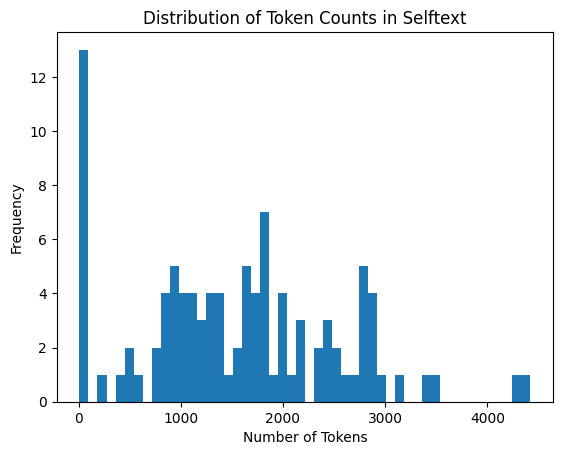

In [7]:
data_subset["token_count"] = data_subset["selftext_preprocessed"].apply(len)
plt.hist(data_subset["token_count"], bins=50)
plt.title("Distribution of Token Counts in Selftext")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

## Creating target

In [8]:
data["link_flair_text"].unique()

array(['not the asshole', 'asshole', 'no assholes here', 'not the a-hole',
       'slight asshole', 'Not the A-hole', 'Asshole', 'asshole (a bit)',
       'Obvious Asshole', 'Asshole (but funny/justified)',
       'justified asshole', 'huge asshole', 'asshole (Kind of)',
       'asshole (tiny bit)', 'Crouching Liar; hidden asshole',
       'Not the A-hole POO Mode', 'Asshole POO Mode'], dtype=object)

In [ ]:
asshole_flairs = ["asshole", 
                  "slight asshole",
                  "Asshole", 
                  "asshole (a bit)", 
                  "Obvious Asshole",
                  "Asshole (but funny/justified)", 
                  "justified asshole",
                  "huge asshole", 
                  "asshole (Kind of)",
                  "asshole (tiny bit)", 
                  "Crouching Liar; hidden asshole",
                  "Not the A-hole POO Mode",
                  "Asshole POO Mode"]

not_enough_info_flairs = ["not enough info",
                          "no assholes here"]

not_an_asshole_flairs = ["not the asshole",
                         "not the a-hole",
                         "Not the A-hole",
                         "Not the A-hole POO Mode'"]


def assign_target(flair):
    if flair in asshole_flairs:
        return 1
    elif flair in not_enough_info_flairs:
        return 2
    elif flair in not_an_asshole_flairs:
        return 0
    else:
        raise ValueError("Unexpected flair: {}".format(flair))

data["target"] = data["link_flair_text"].apply(assign_target)

: 

## Training baseline model

In [ ]:
documents = data["selftext_preprocessed"].tolist()
titles = data["title"].tolist()
tfidfvectorizer = TfidfVectorizer(stop_words="english")
countvectorizer = TfidfVectorizer(stop_words="english", use_idf=False, norm=None)

tfidf = tfidfvectorizer.fit_transform(raw_documents=documents)
tfidf_df = pd.DataFrame(tfidf.todense(), index=titles, columns=tfidfvectorizer.get_feature_names_out())

absolute_tfidf = countvectorizer.fit_transform(raw_documents=documents)
absolute_tfidf_df = pd.DataFrame(absolute_tfidf.todense(), index=titles, columns=countvectorizer.get_feature_names_out())


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, data["target"], test_size=0.2, random_state=42)

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      3136
           1       0.53      0.02      0.05       863

    accuracy                           0.78      3999
   macro avg       0.66      0.51      0.46      3999
weighted avg       0.73      0.78      0.70      3999

F1 Score: 0.046511627906976744
